### Real-Data Benchmarking

This notebook goes over a collection of estimators used to model trend (change in mean) across a time series. Specifically a focus is on trend filtering and it's performance in estimation and computation time against splines, kernels, and segmented regression

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
sys.path.append("../")


PATH = "../../../../taq_db/TAQ-Query-Scripts/data/features/2020-01-02/"
sys.path.append(PATH)

os.listdir(PATH)[:20]

['CNC_reconstructed_features.csv',
 'ABBV_reconstructed_features.csv',
 'BWA_reconstructed_features.csv',
 'GOOG_reconstructed_features.csv',
 'AVGO_reconstructed_features.csv',
 'AME_reconstructed_features.csv',
 'CPT_reconstructed_features.csv',
 'BAX_reconstructed_features.csv',
 'BDX_reconstructed_features.csv',
 'AFL_reconstructed_features.csv',
 'CNP_reconstructed_features.csv',
 'CE_reconstructed_features.csv',
 'ANET_reconstructed_features.csv',
 'APD_reconstructed_features.csv',
 'ADBE_reconstructed_features.csv',
 'BAC_reconstructed_features.csv',
 'AES_reconstructed_features.csv',
 'CHTR_reconstructed_features.csv',
 'ADM_reconstructed_features.csv',
 'CDAY_reconstructed_features.csv']

In [2]:
os.listdir(PATH)

DATA_FILE = "GOOG_reconstructed_features.csv"

In [3]:
market_data = pd.read_csv(PATH + DATA_FILE, index_col=0,nrows=100000)
market_data.index = pd.to_datetime(market_data.index)

trade_data= market_data[market_data["Trade_Volume"] > 0]


/tmp/ipykernel_69558/1857228344.py:1: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  market_data = pd.read_csv(PATH + DATA_FILE, index_col=0,nrows=100000)


### Screening by sale condtion of trades

- Examining only regular trades allows for a much better performace in terms of efficiency and estimation



In [4]:
regular_trades = trade_data[trade_data["Sale_Condition"] == "@   "]
regular_trades.head()

print("Number of trades: ", len(regular_trades))

Number of trades:  878


In [5]:
trade_data["Sale_Condition"].unique()

array(['@ TI', '@F I', '@  Q', '@O X', '@F  ', '@  I', '@   ', '@4 I',
       '@4 W', '@4  ', '@7 V', 'C  I', 'R  I', 'N  I'], dtype=object)

### Visualizing Market Data

Plotted below is AMZN trade price and volume data 

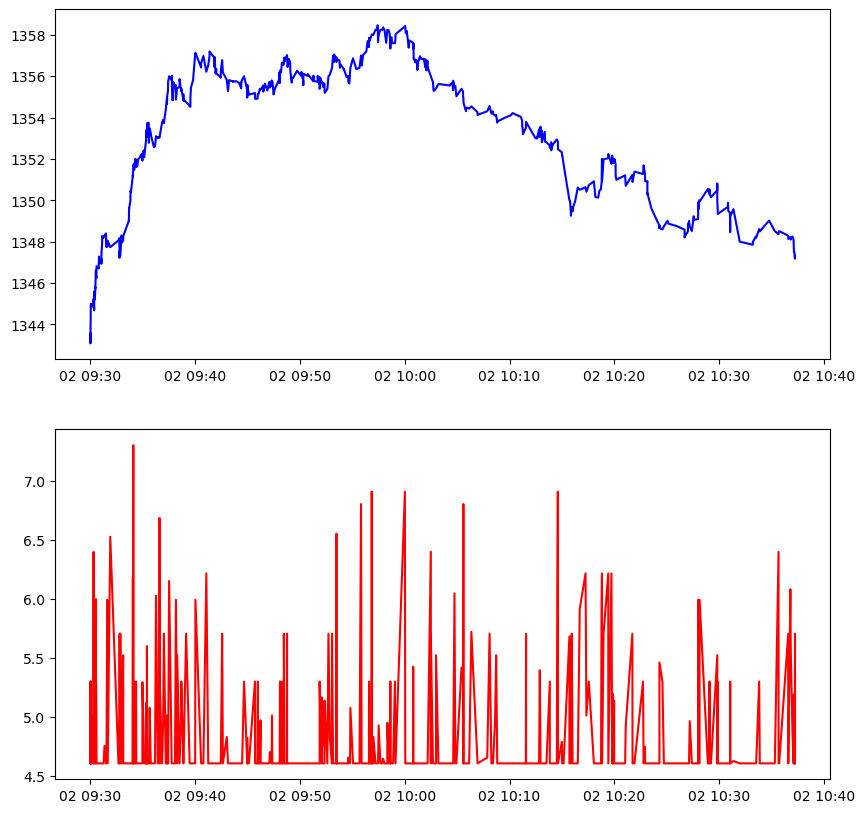

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

trade_price=regular_trades["Trade_Price"]
trade_volume=regular_trades["Trade_Volume"]


ax[0].plot(trade_price, label="Trade Price",color='blue')

ax[1].plot(np.log(trade_volume), label="Log Trade Volume",color='red')



plt.show()



### Quick Performance of Trend Filtering

In [7]:
import sys
sys.path.append("../../")
from estimators.trend_filtering.trend_filter import Trend_Filter

from estimators.cv_base_estimator import cv_base_estimator

In [8]:
x=np.arange(0,len(regular_trades))
tf= Trend_Filter(x=x, y=regular_trades["Trade_Price"].values, k=1, method="primal_dual")

cv_base_estimator(tf)



Performing  0 out of 3 iterations of cross validation
Performing cross validation for lambda = 12.181042361702712
Performing cross validation for lambda = 23.51791082317008
Performing cross validation for lambda = 45.40597701437327
Performing cross validation for lambda = 87.6652166993756
Performing cross validation for lambda = 169.25503478354238
Performing cross validation for lambda = 326.7803112586407
Performing cross validation for lambda = 630.9140047908197
Performing cross validation for lambda = 1218.1042361702712
Performing cross validation for lambda = 2351.791082317008
Performing cross validation for lambda = 4540.5977014373275
Performing cross validation for lambda = 8766.52166993755
Performing cross validation for lambda = 16925.50347835424
Performing cross validation for lambda = 32678.031125864072
Performing cross validation for lambda = 63091.4004790819
Performing cross validation for lambda = 121810.42361702712
Performing  1 out of 3 iterations of cross validation
Perf

{'lambda_': 18.564944155037743}

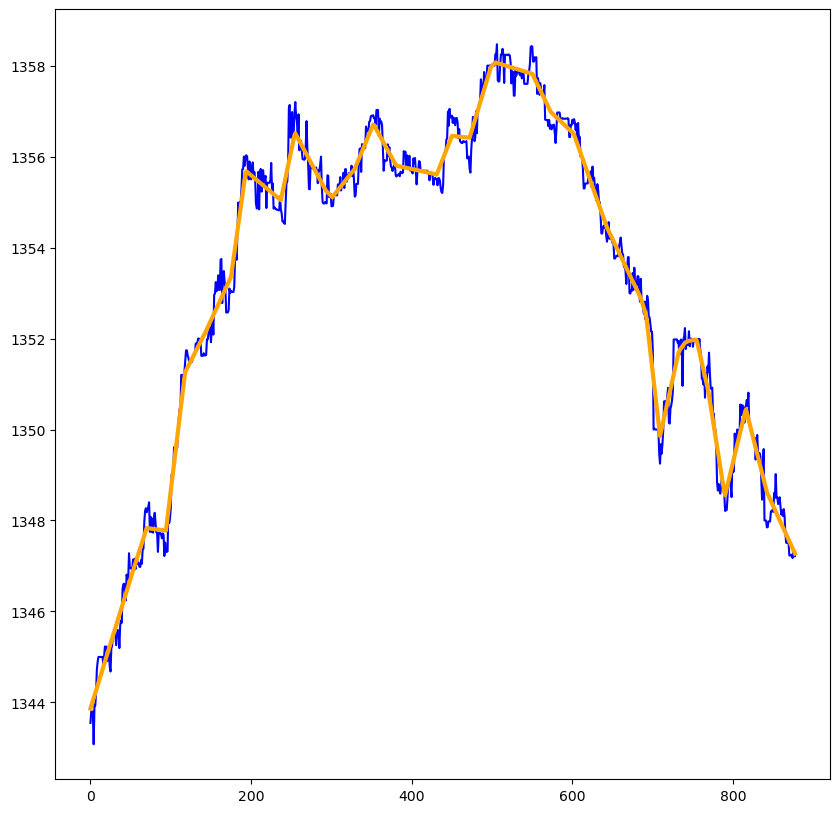

In [9]:


fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(trade_price.values, label="Trade Price",color='blue')

ax.plot(tf.y_hat, label="Estimate",lw=3,color='orange')



### Regime Detection from Estimated Trend

NameError: name 'results' is not defined

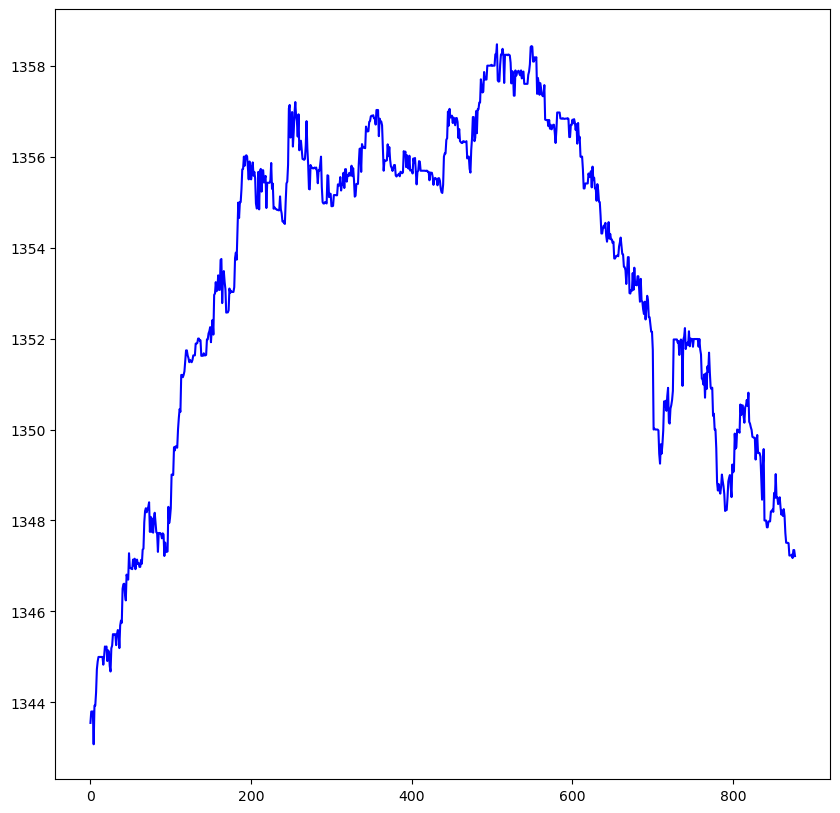

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(trade_price.values, label="AMZN Trade Price",color='blue')
ax.plot(results["sol"].x, label="Estimated Trend ",color='red',lw=3)

for i in range(len(results["sol"].knots)):
    ax.axvline(results["sol"].knots[i],color='black',linestyle='--',label=f"Regime Change {i+1}")

ax.legend()
ax.set_title(" Adaptive Trend Filtering and Regime Change Detection")

quantiles=[0.1,0.25,0.5,0.75,0.9]
indices=[int(len(trade_price.values)*q)-1 for q in quantiles]
ax.set_xticks(indices,regular_trades.index[indices].strftime("%H:%M:%S"))

### Ratio of Loss Functions (Used for Model Selection)

In [ ]:
model_selection=results["sol"].all_models

model_selection

{0: 0.2959366814902373,
 1: 0.2719327884411224,
 2: 1.0016599657778176,
 3: 0.9668175088997614,
 4: 0.9386775537037432,
 5: 1.0018260719217984,
 6: 1.0751173509315213,
 7: 0.9872860023363488,
 8: 0.9531087704754018,
 9: 1.1083811743548742,
 10: 1.0171737109952383,
 11: 1.0514837276573663,
 12: 1.0352628621103526,
 13: 1.0629802961664243}

In [ ]:
results["sol"].optimal_model

2

Text(0.5, 1.0, 'Model Selection')

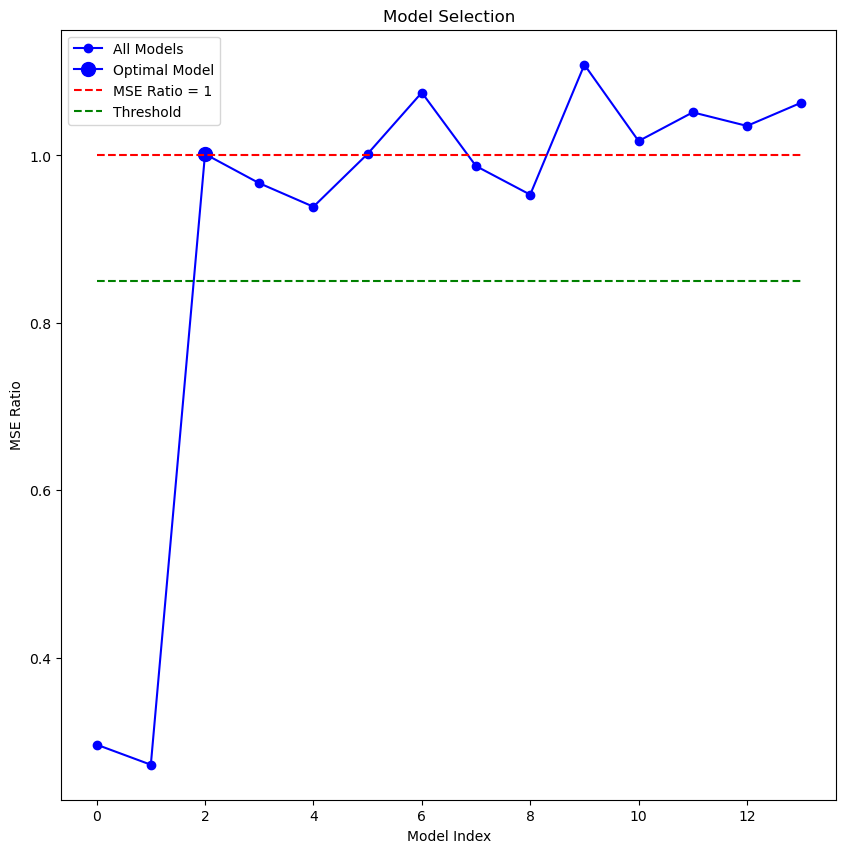

In [ ]:
keys=list(model_selection.keys())
values=list(model_selection.values())
all_other_models=[(i,values[i]) for i in range(len(values)) if i != results["sol"].optimal_model]

nu=get_model_constants()["nu"]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(keys,values,label="All Models",color='blue',marker='o')
ax.plot(results["sol"].optimal_model,model_selection[results["sol"].optimal_model],label="Optimal Model",color='blue',marker='o',markersize=10)
ax.hlines(1,keys[0],keys[-1],color='red',linestyle='--',label="MSE Ratio = 1")
ax.hlines(1-nu,keys[0],keys[-1],color='green',linestyle='--',label="Threshold")

ax.legend()
ax.set_ylabel("MSE Ratio")
ax.set_xlabel("Model Index")
ax.set_title("Model Selection")



### Time Dependent Trend Filtering

Careful consideration to round timestamps for observations with near identical timestamps

In [ ]:
regular_trades['Round_Timestamp'] = regular_trades.index.round('1ms')

round_regular_trades = regular_trades.groupby('Round_Timestamp').agg({'Trade_Price': 'mean', 'Trade_Volume': 'sum'})

round_regular_trades.head()

/tmp/ipykernel_7081/2014949561.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regular_trades['Round_Timestamp'] = regular_trades.index.round('1ms')


,Trade_Price,Trade_Volume
Round_Timestamp,,
2020-01-02 09:30:01.002,1343.55,100.0
2020-01-02 09:30:01.141,1343.80,300.0
2020-01-02 09:30:01.175,1343.08,200.0
2020-01-02 09:30:01.587,1343.93,100.0
2020-01-02 09:30:01.588,1343.93,100.0


In [ ]:
time_trade_price=round_regular_trades["Trade_Price"]

timestamps=round_regular_trades.index-regular_trades.index[0]

timestamps=timestamps.total_seconds().values

D=Difference_Matrix(len(time_trade_price),k=1,t=timestamps)



In [ ]:
best_lambda=cross_validation(time_trade_price.values.reshape(-1,1), D,cv_folds=15,cv_iterations=3,verbose=False)

print(f"Best lambda: {best_lambda}")

Best lambda: 246.0962203417643


In [ ]:
#D=Difference_Matrix(len(trade_price),k=1)

time_results=adaptive_tf(time_trade_price.values.reshape(-1,1), D, best_lambda ,select_knots=True)
time_results

k: 0 mse: 12.61596047189911
k: 1 mse: 3.7307725719258458
k: 2 mse: 0.807042325853252
k: 3 mse: 0.7031119312785625
k: 4 mse: 0.6034416650649901
k: 5 mse: 0.5904038458802157
k: 6 mse: 0.5517689664373528
k: 7 mse: 0.45531120649918455
k: 8 mse: 0.3818276107341124
k: 9 mse: 0.3877032779903711
k: 10 mse: 0.38232287715400004
k: 11 mse: 0.31084209087138714
k: 12 mse: 0.3167177581276458
k: 13 mse: 0.33732825818657863
k: 14 mse: 0.4111650248453935


{'sol': <piecewise_linear_model.Piecewise_Linear_Model at 0x7fd70cafe1d0>,
 'status': 'solved',
 'gap': 8.246518679300152e-05,
 'iters': 28}

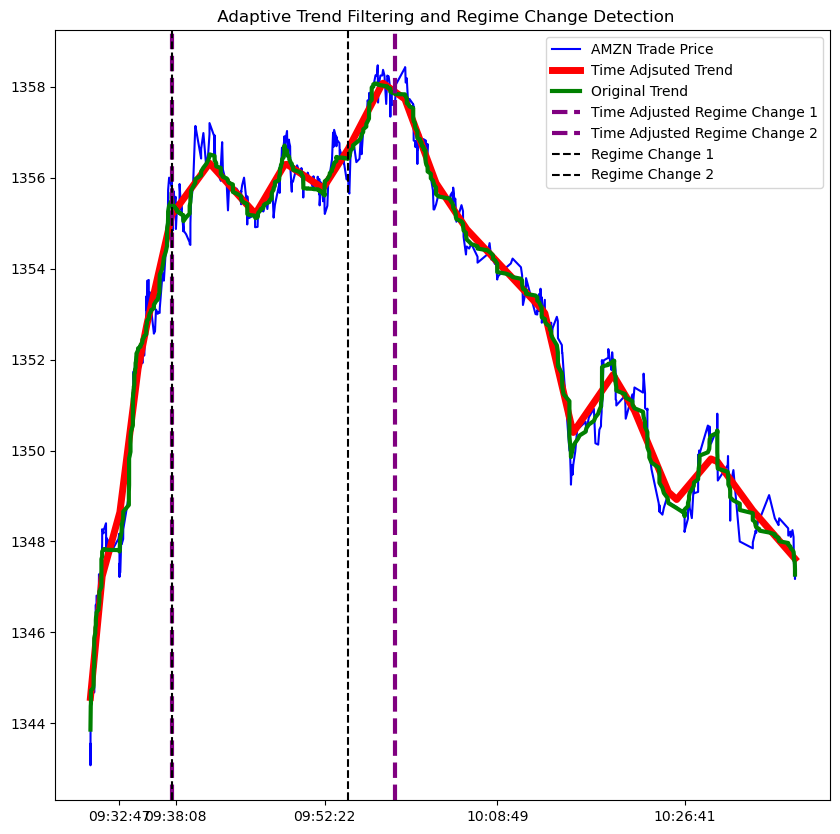

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(trade_price.index,trade_price.values, label="AMZN Trade Price",color='blue')
ax.plot(time_trade_price.index,time_results["sol"].x, label="Time Adjsuted Trend ",color='red',lw=5)
ax.plot(trade_price.index,results["sol"].x, label="Original Trend",color='green',lw=3)

for i in range(len(time_results["sol"].knots)):
    ax.axvline(time_trade_price.index[time_results["sol"].knots[i]],color='purple',linestyle='--',label=f"Time Adjusted Regime Change {i+1}",lw=3)

for i in range(len(results["sol"].knots)):
    ax.axvline(trade_price.index[results["sol"].knots[i]],color='black',linestyle='--',label=f"Regime Change {i+1}")

ax.legend()
ax.set_title(" Adaptive Trend Filtering and Regime Change Detection")

quantiles=[0.1,0.25,0.5,0.75,0.9]
indices=[int(len(trade_price)*q)-1 for q in quantiles]
ax.set_xticks(regular_trades.index[indices],regular_trades.index[indices].strftime("%H:%M:%S"))

Text(0.5, 1.0, 'Model Selection')

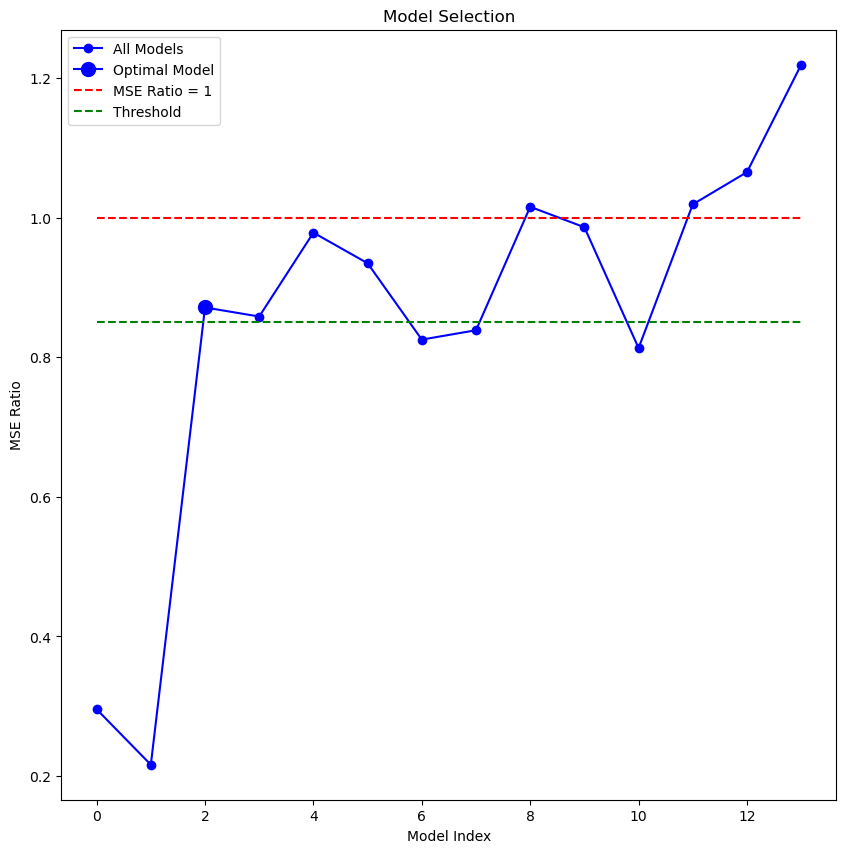

In [ ]:
model_selection=time_results["sol"].all_models

keys=list(model_selection.keys())
values=list(model_selection.values())
all_other_models=[(i,values[i]) for i in range(len(values)) if i != results["sol"].optimal_model]

nu=get_model_constants()["nu"]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(keys,values,label="All Models",color='blue',marker='o')
ax.plot(results["sol"].optimal_model,model_selection[results["sol"].optimal_model],label="Optimal Model",color='blue',marker='o',markersize=10)
ax.hlines(1,keys[0],keys[-1],color='red',linestyle='--',label="MSE Ratio = 1")
ax.hlines(1-nu,keys[0],keys[-1],color='green',linestyle='--',label="Threshold")

ax.legend()
ax.set_ylabel("MSE Ratio")
ax.set_xlabel("Model Index")
ax.set_title("Model Selection")
